# 批量归一化
训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。

批量规范化使得研究人员能够训练100层以上的网络。

现在主流的卷积神经网络几乎都使用了批量归一化 特别是做一些非常深的卷积网络
批量归一化是一种流行且有效的技术，它可以持续加速深层网络的收敛速度

当神经网络非常深的时候
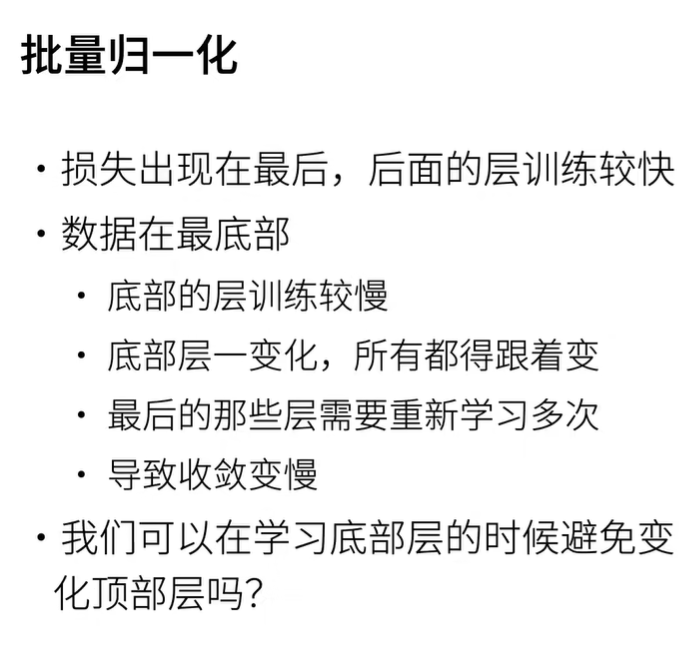

1。使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。 直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。

2.对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测。 批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。 直观地说，我们可能会猜想，如果一个层的可变值是另一层的100倍，这可能需要对学习率进行补偿调整。

3.更深层的网络很复杂，容易过拟合。 这意味着正则化变得更加重要。

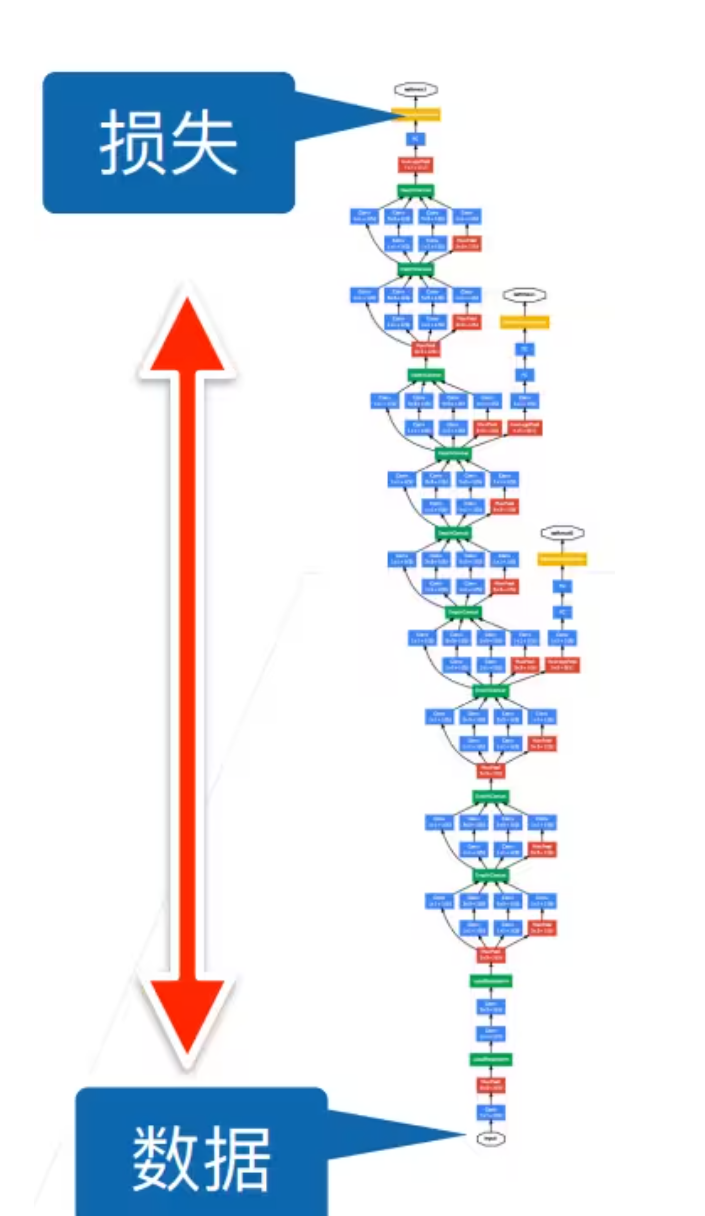

当神经网络比较深的时候会发现：数据在下面，损失函数在上面，这样会出现什么问题？

正向传递的时候，数据是从下往上一步一步往上传递
反向传递的时候，数据是从上面往下传递，这时候就会出现问题：梯度在上面的时候比较大，越到下面就越容易变小（因为是n个很小的数进行相乘，越到后面结果就越小，也就是说越靠近数据的，层的梯度就越小）
上面的梯度比较大，那么每次更新的时候上面的层就会不断地更新；但是下面层因为梯度比较小，所以对权重地更新就比较少，这样的话就会导致上面的收敛比较快，而下面的收敛比较慢，这样就会导致底层靠近数据的内容（网络所尝试抽取的网络底层的特征：简单的局部边缘、纹理等信息）变化比较慢，上层靠近损失的内容（高层语义信息）收敛比较快，所以每一次底层发生变化，所有的层都得跟着变（底层的信息发生变化就导致上层的权重全部白学了），这样就会导致模型的收敛比较慢 

能不能在改变底部信息的时候，避免顶部不断的重新训练？（这也是批量归一化所考虑的问题）

批量归一化（Batch Normalization，简称BatchNorm）是一种用于加速深度神经网络训练并提高其稳定性的方法。它通过在每个小批量（mini-batch）上归一化输入层的激活值来实现这一点。批量归一化有助于缓解梯度消失和梯度爆炸问题，使得网络的训练更加高效和稳定。

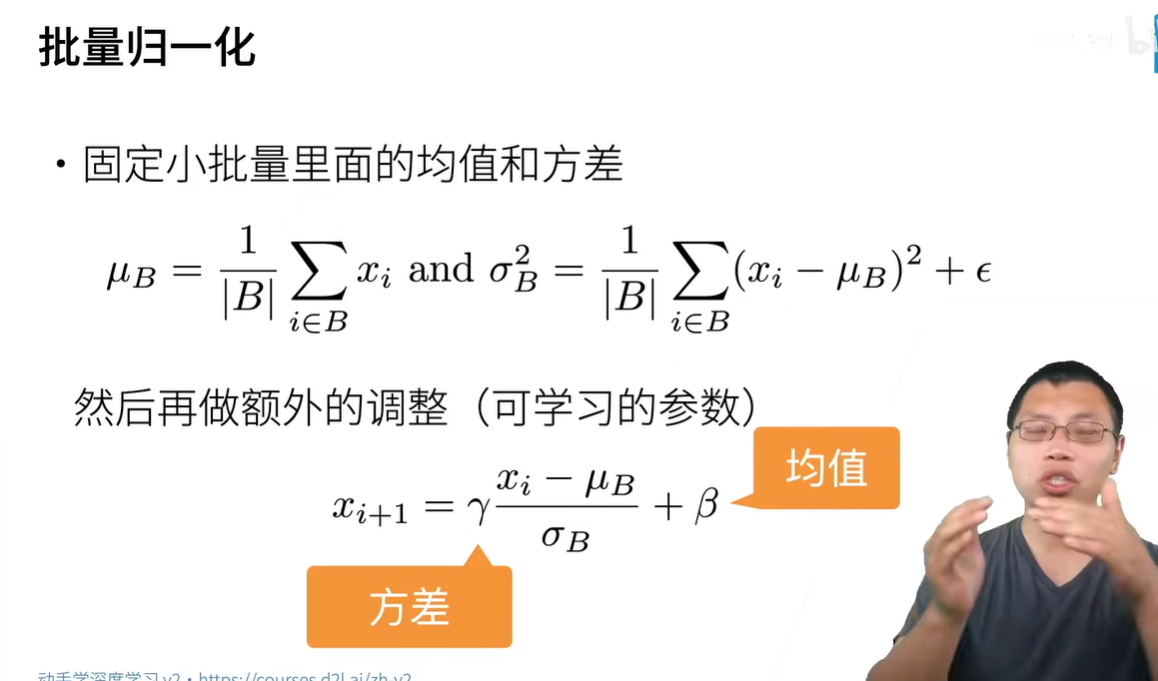

可以通过学习 找到更适合的均值和方差

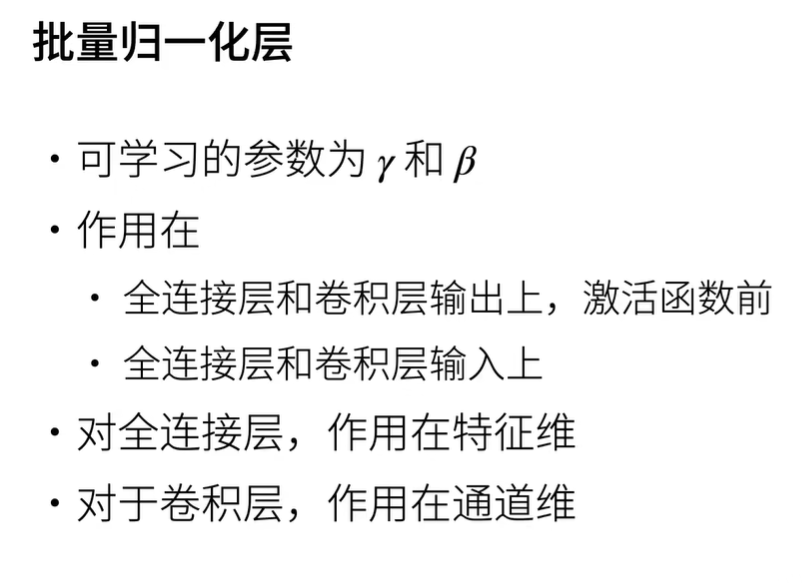

批量归一化在做什么事情
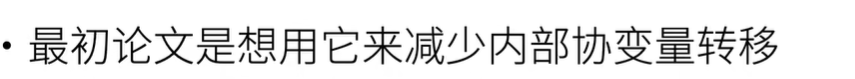

做了一些随机的偏移和缩放 在用学习到的稳定的均值和方差 来使得变化并不剧烈
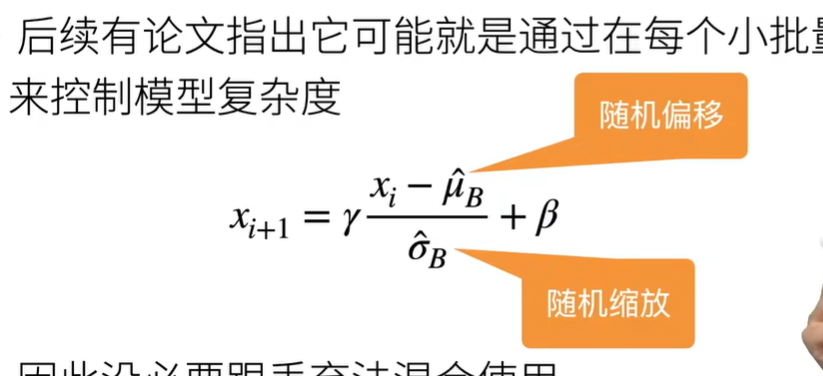

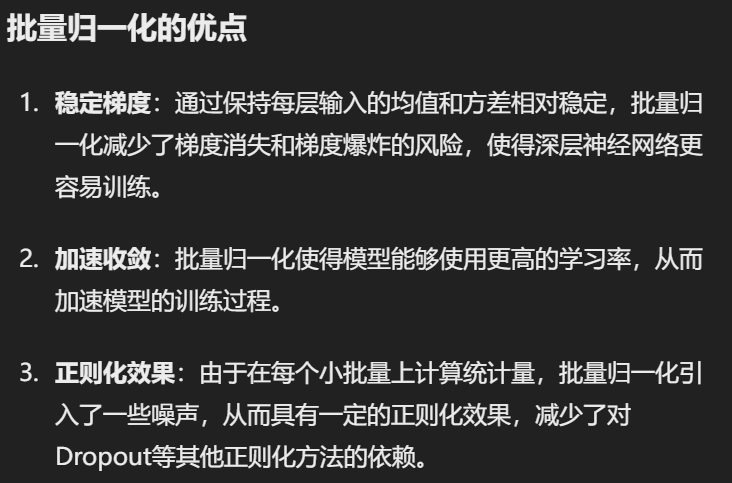

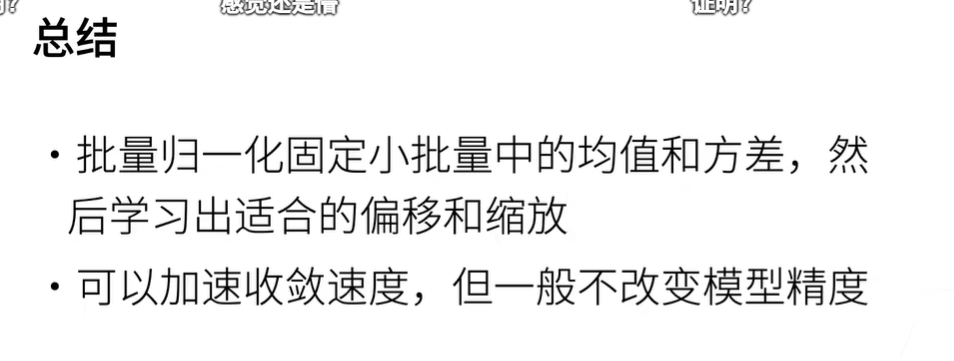

In [5]:
# 批量归一化代码

import torch
from torch import nn
from d2l import torch as d2l

# X是输入张量 gamma缩放参数用于对归一化后的数据进行缩放
#beta平移参数。用于对归一化后的数据进行平移
#moving_mean 移动平均的均值。在训练过程中更新，用于预测时的均值。
#moving_var 移动平均的方差。在训练过程中更新，用于预测时的方差。
#eps 一个很小的正数，用于避免除以零的情况
#momentum 动量参数，用于更新移动平均的均值和方差

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 判断当前是否为训练模式，如果不是，则为预测模式
    if not torch.is_grad_enabled():
        # 预测模式下，使用传入的移动平均均值和方差
        # 使用传入的移动平均所得的均值和方差进行归一化
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 确保输入张量的形状是二维或四维
        # 判断输入的形状是全连接层(2D)还是卷积层(4D)
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 对于全连接层，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 对于卷积层，计算通道维上的均值和方差
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    # 对标准化后的数据进行缩放和平移
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data
    #返回做了线性变化的Y 和m预测的均值和方差oving_mean.data, moving_var.data

In [6]:
import torch
from torch import nn

# 创建一个正确的BatchNorm层
# 这个层将保持适当的参数：拉伸gamma和偏移beta，这两个参数将在训练过程中更新。
# 此外，我们的层将保存均值和方差的移动平均值，以便在模型预测期间随后使用。
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        # 根据 num_dims 确定参数的形状。
        # 对于全连接层，形状为 (1, num_features)；
        # 对于卷积层，形状为 (1, num_features, 1, 1)。
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        # gamma 和 beta 是拉伸和偏移参数，
        # 分别初始化为 1 和 0，并且是参与求梯度和迭代的可学习参数。
        
        #gamma和beta是会被做迭代的
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        
        # 非模型参数的变量初始化为0和1
        # moving_mean 和 moving_var 
        # 用于保存均值和方差的移动平均值，分别初始化为 0 和 1。
        # moving_mean 和 moving_var 是不会被迭代的
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    # 定义一个前向传播方法
    def forward(self, X):
#         它用于判断 self.moving_mean 和 self.moving_var 是否存储在与输入 X 相同的设备（如 CPU 或 GPU）上。
#         如果它们不在相同的设备上，就需要将 self.moving_mean 和 self.moving_var 移动到与 X 相同的设备上，
#         以确保计算在同一设备上进行，从而避免跨设备的计算开销和错误。
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        
        # 保存更新过的moving_mean和moving_var
#         这行代码调用了 batch_norm 函数，并将其结果赋值给 Y、self.moving_mean 和 self.moving_var。
#         具体来说，这里执行了批量归一化操作，并更新了均值和方差的移动平均值。
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [8]:
#应用BatchNorm于LeNet模型
# 创建一个LeNet模型，并在每个卷积层和全连接层后应用BatchNorm层
net = nn.Sequential(
    # 第一个卷积层
    # 输入通道数为1，输出通道数为6，卷积核大小为5x5
    nn.Conv2d(1, 6, kernel_size=5), 
    
    # 应用BatchNorm层
    # 输出通道数为6，num_dims为4，表示卷积层
    BatchNorm(6, num_dims=4), 
    
    # 应用Sigmoid激活函数
    nn.Sigmoid(),
    
    # 第一个平均池化层
    # 池化核大小为2x2，步幅为2
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    # 第二个卷积层
    # 输入通道数为6，输出通道数为16，卷积核大小为5x5
    nn.Conv2d(6, 16, kernel_size=5), 
    
    # 应用BatchNorm层
    # 输出通道数为16，num_dims为4，表示卷积层
    BatchNorm(16, num_dims=4), 
    
    # 应用Sigmoid激活函数
    nn.Sigmoid(),
    
    # 第二个平均池化层
    # 池化核大小为2x2，步幅为2
    nn.AvgPool2d(kernel_size=2, stride=2), 
    
    # 将多维输入展平为一维
    nn.Flatten(),
    
    # 第一个全连接层
    # 输入大小为16*4*4（16个通道，每个通道4x4），输出大小为120
    nn.Linear(16*4*4, 120), 
    
    # 应用BatchNorm层
    # 输出大小为120，num_dims为2，表示全连接层
    BatchNorm(120, num_dims=2), 
    
    # 应用Sigmoid激活函数
    nn.Sigmoid(),
    
    # 第二个全连接层
    # 输入大小为120，输出大小为84
    nn.Linear(120, 84), 
    
    # 应用BatchNorm层
    # 输出大小为84，num_dims为2，表示全连接层
    BatchNorm(84, num_dims=2), 
    
    # 应用Sigmoid激活函数
    nn.Sigmoid(),
    
    # 第三个全连接层（输出层） 作为输出层 不加其他东西
    # 输入大小为84，输出大小为10（分类数目为10）
    nn.Linear(84, 10)
)

loss 0.266, train acc 0.902, test acc 0.845
38701.4 examples/sec on cuda:0


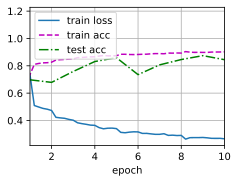

In [9]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [10]:
# 让我们来看看从第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta。
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([4.4489, 2.0458, 1.7808, 2.2686, 2.0485, 3.4218], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-2.4432,  2.3455, -0.8502,  0.8260,  2.7141, -2.6214], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [11]:
#可以不用定义的简明实现

net = nn.Sequential(
#     nn.BatchNorm2d()对于卷积来说参数是输出通道数
#     对于线性层是输出的大小
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.264, train acc 0.903, test acc 0.771
65972.6 examples/sec on cuda:0


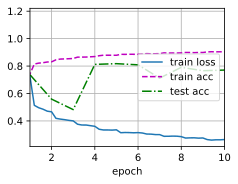

In [12]:
#使用相同的超参数进行训练模型
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

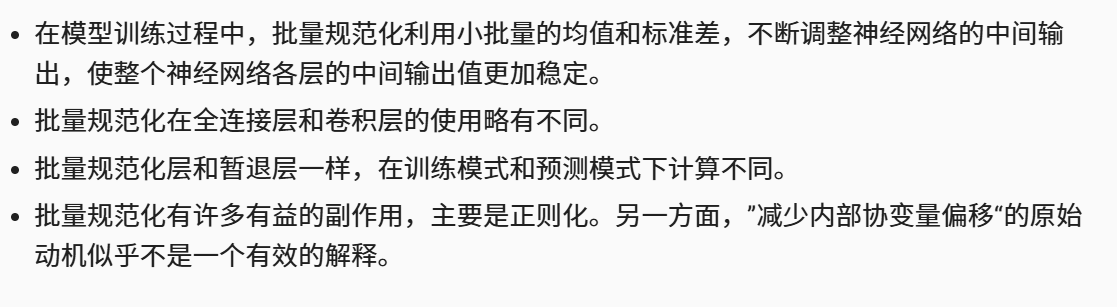